In [1]:
import os
import numpy as np
import pandas as pd
from pickle import dump, load

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
SEED = 42
np.random.seed(SEED)
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
LABEL_COLUMN = 'price'

In [104]:
# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    y = df[LABEL_COLUMN].values
    x = df.drop(columns=[LABEL_COLUMN])
    return x, y

In [105]:
dataset_date = '20200602'
work_dir = '/Users/ruitao/WorkDocs/Code/diamonds/data/{}/'.format(dataset_date)

In [106]:
file_path = os.path.join(work_dir, 'raw.csv')
X, y = load_data(file_path)

In [107]:
# Split train/validation/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print("Training data shape: {}".format(X_train.shape))

Training data shape: (11764, 29)


In [108]:
# Diamond fluorescence itself is a debated topic, see https://www.leibish.com/diamond-fluorescence-article-245
# [TODO] Explore how different pair of color + fluorescence may result in different price
# Also use ordinal encoding now for Fluorescence, the ordinal may be a wrong assumption
# Now we just simplify based on UV light intensity
def map_fluorescence(x):
    if x == 'None':
        return 'None'
    elif 'Faint' in x:
        return 'Faint'
    elif 'Medium' in x:
        return 'Medium'
    elif 'Very Strong' in x:
        return 'Very Strong'
    elif 'Strong' in x:
        return 'Strong'
    
fluorescence = ['Very Strong', 'Strong', 'Medium', 'Faint', 'None']
# ranking: the bigger the better
ranking = {
    'clarity': ['I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'],
    'color': ['K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'],
    'cut': ['Good', 'Very Good', 'Ideal', 'Astor Ideal'], # https://www.bluenile.com/education/diamonds/cut
    'culet': ['Medium', 'Small', 'Very Small', 'Pointed', 'None'],
    'polish': ['Good', 'Very Good', 'Excellent'],
    'symmetry': ['Good', 'Very Good', 'Excellent'],
}

In [111]:
# Prepare Input
scaler_path = os.path.join(work_dir, 'scaler.pkl')

def prepare_input(df, y, train=False):
    """
        Input:
            x: pandas dataframe
        Output:
            x_num: (numpy array) numerical input features
            colnames: (list) column names
    """
    # split measurements
    measurements = df['measurements'].str.replace(' mm', '').str.split(' x ', expand=True)
    measurements = measurements.apply(pd.to_numeric)
    measurements.columns = ['length', 'width', 'height']
    df = df.join(measurements)
    
    # ordinal encoding (can't use pd.Categorical, in case missing certain categories)
    for key, value in ranking.items():
        value_map = {k: v for v, k in enumerate(value)}
        df['ord_{}'.format(key)] = df[key].map(value_map)
    
    # add categorical features 
    # onehot encoding Fluorescence (no straightforward ordering)
    df['fluorescence'] = df['fluorescence'].map(map_fluorescence) # reduce fluorescence options
    enc = OneHotEncoder(categories=[fluorescence], sparse=False)
    x_fluors = enc.fit_transform(df['fluorescence'].values.reshape(-1, 1))
    
    x_visual = df['hasVisualization'].astype(int).values.reshape(-1, 1)
    
    # select columns used in model
    cols_num = ['carat', 'depth', 'lxwRatio', 'table', 'sellingIndex', 'length', 'width', 'height']
    cols_ord = ['ord_{}'.format(key) for key in ranking.keys()]
    
    # polynomials (degree 2) for numerical+ordinal turn out to be useful
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    x_poly = poly_features.fit_transform(df[cols_num + cols_ord].values)
    
    # apply MinMax scale to only numerical+ordinal features
    if train:
        scaler = MinMaxScaler()
        scaler.fit(x_poly)
        # save scalar
        dump(scaler, open(scaler_path, 'wb'))
    else:
        scaler = load(open(scaler_path, 'rb'))
    
    # transform x
    x_minmax = scaler.transform(x_poly)
    print(x_minmax.shape)
    
    x = np.hstack((x_minmax, x_fluors, x_visual))
    print("X shape: ", x.shape)
    x = x.astype("float32")
    y = y.astype("float32")
    
    return x, y

In [112]:
X_train_scaled, y_train_scaled = prepare_input(X_train, y_train, train=True)
X_test_scaled, y_test_scaled = prepare_input(X_test, y_test, train=False)

(11764, 119)
X shape:  (11764, 125)
(2941, 119)
X shape:  (2941, 125)


In [113]:
m, n = X_train_scaled.shape
print("Training data shape after transformation: {}".format(X_train_scaled.shape))

Training data shape after transformation: (11764, 125)


In [114]:
# Initial loss benchmark - if we always predict the average price of the training set, what is the mse
y_train_fake = np.ones(len(y_train_scaled)) * np.mean(y_train_scaled)

print("Baseline mean_squared_error: {}".format(mean_squared_error(y_train_fake, y_train_scaled)))
print("Baseline mean_absolute_error: {}".format(mean_absolute_error(y_train_fake, y_train_scaled)))
print("Baseline r2: {}".format(r2_score(y_train_fake, y_train_scaled)))

Baseline mean_squared_error: 18636340.198987976
Baseline mean_absolute_error: 3461.892447296838
Baseline r2: 0.0


In [125]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation="relu", input_shape=(n,)),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])
#model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])

# checkpoint
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(work_dir, "dropout_weights.best.hdf5"), 
                                       monitor='val_mae', verbose=1, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(work_dir, 'logs'))
]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               32256     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 89,985
Trainable params: 89,985
Non-trainable params: 0
_________________________________________________

In [126]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=2000, batch_size=128, validation_split=0.2, verbose=2, callbacks=callbacks_list)

Train on 9411 samples, validate on 2353 samples
Epoch 1/2000

Epoch 00001: val_mae improved from inf to 2605.11841, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 2s - loss: 60560981.5471 - root_mean_squared_error: 7782.0947 - mae: 5680.3716 - val_loss: 11141909.1028 - val_root_mean_squared_error: 3337.9497 - val_mae: 2605.1184
Epoch 2/2000

Epoch 00002: val_mae improved from 2605.11841 to 1917.09290, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 11736334.9862 - root_mean_squared_error: 3425.8328 - mae: 2684.2307 - val_loss: 6402890.6334 - val_root_mean_squared_error: 2530.3933 - val_mae: 1917.0929
Epoch 3/2000

Epoch 00003: val_mae improved from 1917.09290 to 1487.21167, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 8082470.2316 - root_mean_squared_error: 2842.9685 - mae: 2197.3416 - val_lo

Epoch 29/2000

Epoch 00029: val_mae did not improve from 905.68054
9411/9411 - 1s - loss: 5063749.5935 - root_mean_squared_error: 2250.2776 - mae: 1741.5492 - val_loss: 1847354.2488 - val_root_mean_squared_error: 1359.1741 - val_mae: 1089.2487
Epoch 30/2000

Epoch 00030: val_mae did not improve from 905.68054
9411/9411 - 1s - loss: 5345726.3730 - root_mean_squared_error: 2312.0825 - mae: 1807.2275 - val_loss: 3144175.0197 - val_root_mean_squared_error: 1773.1821 - val_mae: 1396.2402
Epoch 31/2000

Epoch 00031: val_mae improved from 905.68054 to 902.99585, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 4631576.0164 - root_mean_squared_error: 2152.1096 - mae: 1659.2860 - val_loss: 1563300.2385 - val_root_mean_squared_error: 1250.3201 - val_mae: 902.9958
Epoch 32/2000

Epoch 00032: val_mae did not improve from 902.99585
9411/9411 - 1s - loss: 4450538.4746 - root_mean_squared_error: 2109.6299 - mae: 1623.8834 - val_loss: 

Epoch 62/2000

Epoch 00062: val_mae did not improve from 825.10461
9411/9411 - 1s - loss: 4538470.2079 - root_mean_squared_error: 2130.3687 - mae: 1639.2671 - val_loss: 1308274.5713 - val_root_mean_squared_error: 1143.7983 - val_mae: 846.9748
Epoch 63/2000

Epoch 00063: val_mae did not improve from 825.10461
9411/9411 - 1s - loss: 4287379.1807 - root_mean_squared_error: 2070.5986 - mae: 1588.4473 - val_loss: 1665547.0321 - val_root_mean_squared_error: 1290.5608 - val_mae: 966.9511
Epoch 64/2000

Epoch 00064: val_mae did not improve from 825.10461
9411/9411 - 1s - loss: 4531420.9826 - root_mean_squared_error: 2128.7136 - mae: 1646.3256 - val_loss: 3703441.0653 - val_root_mean_squared_error: 1924.4326 - val_mae: 1573.8599
Epoch 65/2000

Epoch 00065: val_mae did not improve from 825.10461
9411/9411 - 1s - loss: 5035416.7456 - root_mean_squared_error: 2243.9734 - mae: 1730.1234 - val_loss: 2675449.4483 - val_root_mean_squared_error: 1635.6801 - val_mae: 1318.6396
Epoch 66/2000

Epoch 00066


Epoch 00094: val_mae did not improve from 798.44116
9411/9411 - 1s - loss: 4203152.2715 - root_mean_squared_error: 2050.1592 - mae: 1571.1382 - val_loss: 2132291.2870 - val_root_mean_squared_error: 1460.2368 - val_mae: 1134.4459
Epoch 95/2000

Epoch 00095: val_mae did not improve from 798.44116
9411/9411 - 1s - loss: 4355825.7344 - root_mean_squared_error: 2087.0615 - mae: 1609.1322 - val_loss: 1647215.4857 - val_root_mean_squared_error: 1283.4388 - val_mae: 971.6902
Epoch 96/2000

Epoch 00096: val_mae did not improve from 798.44116
9411/9411 - 1s - loss: 4319369.7262 - root_mean_squared_error: 2078.3091 - mae: 1589.6993 - val_loss: 1175030.0326 - val_root_mean_squared_error: 1083.9882 - val_mae: 814.2847
Epoch 97/2000

Epoch 00097: val_mae did not improve from 798.44116
9411/9411 - 1s - loss: 4246794.7863 - root_mean_squared_error: 2060.7754 - mae: 1580.8192 - val_loss: 1336245.0561 - val_root_mean_squared_error: 1155.9606 - val_mae: 878.7228
Epoch 98/2000

Epoch 00098: val_mae did n

Epoch 128/2000

Epoch 00128: val_mae did not improve from 789.13806
9411/9411 - 1s - loss: 4116017.9712 - root_mean_squared_error: 2028.7971 - mae: 1560.8518 - val_loss: 1377412.3318 - val_root_mean_squared_error: 1173.6321 - val_mae: 868.1505
Epoch 129/2000

Epoch 00129: val_mae improved from 789.13806 to 786.87561, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 4383046.0553 - root_mean_squared_error: 2093.5725 - mae: 1599.0594 - val_loss: 1134322.4786 - val_root_mean_squared_error: 1065.0458 - val_mae: 786.8756
Epoch 130/2000

Epoch 00130: val_mae did not improve from 786.87561
9411/9411 - 1s - loss: 4117631.0752 - root_mean_squared_error: 2029.1947 - mae: 1567.7548 - val_loss: 1638111.9309 - val_root_mean_squared_error: 1279.8875 - val_mae: 1011.7642
Epoch 131/2000

Epoch 00131: val_mae did not improve from 786.87561
9411/9411 - 1s - loss: 4113917.2614 - root_mean_squared_error: 2028.2791 - mae: 1561.3292 - val_los

Epoch 161/2000

Epoch 00161: val_mae did not improve from 769.38562
9411/9411 - 1s - loss: 4154762.6929 - root_mean_squared_error: 2038.3235 - mae: 1570.8279 - val_loss: 1159569.4587 - val_root_mean_squared_error: 1076.8331 - val_mae: 784.3769
Epoch 162/2000

Epoch 00162: val_mae did not improve from 769.38562
9411/9411 - 1s - loss: 4198804.5807 - root_mean_squared_error: 2049.0986 - mae: 1567.4948 - val_loss: 1192621.2760 - val_root_mean_squared_error: 1092.0720 - val_mae: 808.6051
Epoch 163/2000

Epoch 00163: val_mae did not improve from 769.38562
9411/9411 - 1s - loss: 4769175.2872 - root_mean_squared_error: 2183.8442 - mae: 1688.1672 - val_loss: 1414196.0650 - val_root_mean_squared_error: 1189.1998 - val_mae: 880.5956
Epoch 164/2000

Epoch 00164: val_mae did not improve from 769.38562
9411/9411 - 1s - loss: 4115638.9619 - root_mean_squared_error: 2028.7037 - mae: 1563.1670 - val_loss: 1247038.2159 - val_root_mean_squared_error: 1116.7086 - val_mae: 821.3541
Epoch 165/2000

Epoch 00

Epoch 195/2000

Epoch 00195: val_mae did not improve from 766.92584
9411/9411 - 1s - loss: 4186067.0139 - root_mean_squared_error: 2045.9879 - mae: 1578.4659 - val_loss: 1596778.3209 - val_root_mean_squared_error: 1263.6370 - val_mae: 941.0323
Epoch 196/2000

Epoch 00196: val_mae improved from 766.92584 to 758.12054, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 4083872.6865 - root_mean_squared_error: 2020.8594 - mae: 1556.1743 - val_loss: 1056483.3709 - val_root_mean_squared_error: 1027.8538 - val_mae: 758.1205
Epoch 197/2000

Epoch 00197: val_mae did not improve from 758.12054
9411/9411 - 1s - loss: 4043069.8170 - root_mean_squared_error: 2010.7386 - mae: 1551.6111 - val_loss: 1156053.2877 - val_root_mean_squared_error: 1075.1992 - val_mae: 782.3630
Epoch 198/2000

Epoch 00198: val_mae improved from 758.12054 to 745.91248, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5


Epoch 228/2000

Epoch 00228: val_mae did not improve from 736.23053
9411/9411 - 1s - loss: 4054257.8633 - root_mean_squared_error: 2013.5188 - mae: 1550.0488 - val_loss: 1259143.4162 - val_root_mean_squared_error: 1122.1156 - val_mae: 828.4207
Epoch 229/2000

Epoch 00229: val_mae did not improve from 736.23053
9411/9411 - 1s - loss: 4029549.0333 - root_mean_squared_error: 2007.3738 - mae: 1546.6206 - val_loss: 2637132.9177 - val_root_mean_squared_error: 1623.9253 - val_mae: 1290.9568
Epoch 230/2000

Epoch 00230: val_mae did not improve from 736.23053
9411/9411 - 1s - loss: 3963989.1126 - root_mean_squared_error: 1990.9768 - mae: 1527.8890 - val_loss: 1451441.0565 - val_root_mean_squared_error: 1204.7577 - val_mae: 895.0174
Epoch 231/2000

Epoch 00231: val_mae did not improve from 736.23053
9411/9411 - 1s - loss: 3915856.9737 - root_mean_squared_error: 1978.8524 - mae: 1533.0250 - val_loss: 1081064.7646 - val_root_mean_squared_error: 1039.7427 - val_mae: 750.7713
Epoch 232/2000

Epoch 0

Epoch 262/2000

Epoch 00262: val_mae did not improve from 735.42175
9411/9411 - 1s - loss: 4052354.4387 - root_mean_squared_error: 2013.0459 - mae: 1538.6978 - val_loss: 1723875.8787 - val_root_mean_squared_error: 1312.9645 - val_mae: 977.9551
Epoch 263/2000

Epoch 00263: val_mae did not improve from 735.42175
9411/9411 - 1s - loss: 3955054.8792 - root_mean_squared_error: 1988.7321 - mae: 1522.1992 - val_loss: 1364093.3425 - val_root_mean_squared_error: 1167.9441 - val_mae: 864.5172
Epoch 264/2000

Epoch 00264: val_mae did not improve from 735.42175
9411/9411 - 1s - loss: 4061855.0844 - root_mean_squared_error: 2015.4045 - mae: 1550.5573 - val_loss: 1202279.3581 - val_root_mean_squared_error: 1096.4850 - val_mae: 806.6602
Epoch 265/2000

Epoch 00265: val_mae did not improve from 735.42175
9411/9411 - 1s - loss: 4015897.5642 - root_mean_squared_error: 2003.9706 - mae: 1544.2769 - val_loss: 1208521.4316 - val_root_mean_squared_error: 1099.3276 - val_mae: 795.2775
Epoch 266/2000

Epoch 00

Epoch 296/2000

Epoch 00296: val_mae did not improve from 725.86670
9411/9411 - 1s - loss: 3880025.9736 - root_mean_squared_error: 1969.7783 - mae: 1507.8973 - val_loss: 1036484.3446 - val_root_mean_squared_error: 1018.0788 - val_mae: 746.7734
Epoch 297/2000

Epoch 00297: val_mae did not improve from 725.86670
9411/9411 - 1s - loss: 3955595.5335 - root_mean_squared_error: 1988.8678 - mae: 1535.2300 - val_loss: 1027968.5409 - val_root_mean_squared_error: 1013.8878 - val_mae: 744.0247
Epoch 298/2000

Epoch 00298: val_mae improved from 725.86670 to 725.02942, saving model to /Users/ruitao/WorkDocs/Code/diamonds/data/20200602/dropout_weights.best.hdf5
9411/9411 - 1s - loss: 3983830.3934 - root_mean_squared_error: 1995.9537 - mae: 1540.8735 - val_loss: 1003085.8352 - val_root_mean_squared_error: 1001.5417 - val_mae: 725.0294
Epoch 299/2000

Epoch 00299: val_mae did not improve from 725.02942
9411/9411 - 1s - loss: 3870461.5748 - root_mean_squared_error: 1967.3489 - mae: 1510.7593 - val_loss

Epoch 328/2000

Epoch 00328: val_mae did not improve from 718.27728
9411/9411 - 1s - loss: 3989319.0761 - root_mean_squared_error: 1997.3280 - mae: 1539.4744 - val_loss: 1390172.4229 - val_root_mean_squared_error: 1179.0557 - val_mae: 883.1611
Epoch 329/2000

Epoch 00329: val_mae did not improve from 718.27728
9411/9411 - 1s - loss: 3826597.4448 - root_mean_squared_error: 1956.1688 - mae: 1509.9069 - val_loss: 1047251.8475 - val_root_mean_squared_error: 1023.3533 - val_mae: 735.4327
Epoch 330/2000

Epoch 00330: val_mae did not improve from 718.27728
9411/9411 - 1s - loss: 3984325.6684 - root_mean_squared_error: 1996.0776 - mae: 1545.2950 - val_loss: 1011043.2713 - val_root_mean_squared_error: 1005.5065 - val_mae: 741.7119
Epoch 331/2000

Epoch 00331: val_mae did not improve from 718.27728
9411/9411 - 1s - loss: 3945929.4952 - root_mean_squared_error: 1986.4364 - mae: 1537.0499 - val_loss: 1124901.7093 - val_root_mean_squared_error: 1060.6138 - val_mae: 765.3292
Epoch 332/2000

Epoch 00

Epoch 361/2000

Epoch 00361: val_mae did not improve from 716.39288
9411/9411 - 1s - loss: 3914732.7464 - root_mean_squared_error: 1978.5684 - mae: 1522.3793 - val_loss: 1137288.8988 - val_root_mean_squared_error: 1066.4375 - val_mae: 815.1923
Epoch 362/2000

Epoch 00362: val_mae did not improve from 716.39288
9411/9411 - 1s - loss: 3961461.9518 - root_mean_squared_error: 1990.3420 - mae: 1531.8425 - val_loss: 1145970.2414 - val_root_mean_squared_error: 1070.5000 - val_mae: 799.6537
Epoch 363/2000

Epoch 00363: val_mae did not improve from 716.39288
9411/9411 - 1s - loss: 3824970.9714 - root_mean_squared_error: 1955.7532 - mae: 1512.5735 - val_loss: 970877.9815 - val_root_mean_squared_error: 985.3314 - val_mae: 721.0799
Epoch 364/2000

Epoch 00364: val_mae did not improve from 716.39288
9411/9411 - 1s - loss: 3938031.6676 - root_mean_squared_error: 1984.4475 - mae: 1538.1263 - val_loss: 1051718.9614 - val_root_mean_squared_error: 1025.5334 - val_mae: 774.4707
Epoch 365/2000

Epoch 0036

Epoch 394/2000

Epoch 00394: val_mae did not improve from 707.69843
9411/9411 - 1s - loss: 3794312.6726 - root_mean_squared_error: 1947.8995 - mae: 1510.1589 - val_loss: 987247.7013 - val_root_mean_squared_error: 993.6035 - val_mae: 725.4276
Epoch 395/2000

Epoch 00395: val_mae did not improve from 707.69843
9411/9411 - 1s - loss: 3804286.2249 - root_mean_squared_error: 1950.4579 - mae: 1499.2104 - val_loss: 1014840.0303 - val_root_mean_squared_error: 1007.3927 - val_mae: 729.1726
Epoch 396/2000

Epoch 00396: val_mae did not improve from 707.69843
9411/9411 - 1s - loss: 3858095.1453 - root_mean_squared_error: 1964.2035 - mae: 1518.8274 - val_loss: 1098555.4032 - val_root_mean_squared_error: 1048.1200 - val_mae: 776.0203
Epoch 397/2000

Epoch 00397: val_mae did not improve from 707.69843
9411/9411 - 1s - loss: 3767996.9186 - root_mean_squared_error: 1941.1329 - mae: 1495.1847 - val_loss: 987718.0348 - val_root_mean_squared_error: 993.8401 - val_mae: 742.7636
Epoch 398/2000

Epoch 00398:

Epoch 428/2000

Epoch 00428: val_mae did not improve from 695.72937
9411/9411 - 1s - loss: 3980394.7156 - root_mean_squared_error: 1995.0927 - mae: 1549.8339 - val_loss: 984040.5042 - val_root_mean_squared_error: 991.9882 - val_mae: 718.4662
Epoch 429/2000

Epoch 00429: val_mae did not improve from 695.72937
9411/9411 - 1s - loss: 3903134.3711 - root_mean_squared_error: 1975.6353 - mae: 1518.4738 - val_loss: 1042588.6596 - val_root_mean_squared_error: 1021.0723 - val_mae: 739.5158
Epoch 430/2000

Epoch 00430: val_mae did not improve from 695.72937
9411/9411 - 1s - loss: 3814388.1015 - root_mean_squared_error: 1953.0459 - mae: 1507.7524 - val_loss: 985958.4559 - val_root_mean_squared_error: 992.9544 - val_mae: 736.9228
Epoch 431/2000

Epoch 00431: val_mae did not improve from 695.72937
9411/9411 - 1s - loss: 3735730.0595 - root_mean_squared_error: 1932.8036 - mae: 1494.9150 - val_loss: 1015565.0934 - val_root_mean_squared_error: 1007.7524 - val_mae: 726.4043
Epoch 432/2000

Epoch 00432:

Epoch 462/2000

Epoch 00462: val_mae did not improve from 687.36597
9411/9411 - 1s - loss: 3578535.5138 - root_mean_squared_error: 1891.7019 - mae: 1455.4441 - val_loss: 1102648.3170 - val_root_mean_squared_error: 1050.0706 - val_mae: 782.7074
Epoch 463/2000

Epoch 00463: val_mae did not improve from 687.36597
9411/9411 - 1s - loss: 3803879.6230 - root_mean_squared_error: 1950.3538 - mae: 1507.9310 - val_loss: 909382.0545 - val_root_mean_squared_error: 953.6152 - val_mae: 695.0385
Epoch 464/2000

Epoch 00464: val_mae did not improve from 687.36597
9411/9411 - 1s - loss: 3541731.8795 - root_mean_squared_error: 1881.9490 - mae: 1457.5627 - val_loss: 976564.7475 - val_root_mean_squared_error: 988.2129 - val_mae: 732.0894
Epoch 465/2000

Epoch 00465: val_mae did not improve from 687.36597
9411/9411 - 1s - loss: 3803857.8740 - root_mean_squared_error: 1950.3480 - mae: 1499.2928 - val_loss: 1000303.0664 - val_root_mean_squared_error: 1000.1514 - val_mae: 729.8478
Epoch 466/2000

Epoch 00466:

Epoch 496/2000

Epoch 00496: val_mae did not improve from 686.97314
9411/9411 - 1s - loss: 3638855.0043 - root_mean_squared_error: 1907.5782 - mae: 1465.9012 - val_loss: 1069507.8083 - val_root_mean_squared_error: 1034.1702 - val_mae: 757.1822
Epoch 497/2000

Epoch 00497: val_mae did not improve from 686.97314
9411/9411 - 1s - loss: 3603652.8361 - root_mean_squared_error: 1898.3290 - mae: 1468.5436 - val_loss: 928837.9341 - val_root_mean_squared_error: 963.7625 - val_mae: 698.3293
Epoch 498/2000

Epoch 00498: val_mae did not improve from 686.97314
9411/9411 - 1s - loss: 3608911.3625 - root_mean_squared_error: 1899.7136 - mae: 1461.0129 - val_loss: 924902.9677 - val_root_mean_squared_error: 961.7188 - val_mae: 705.8097
Epoch 499/2000

Epoch 00499: val_mae did not improve from 686.97314
9411/9411 - 1s - loss: 3829712.5405 - root_mean_squared_error: 1956.9651 - mae: 1510.8585 - val_loss: 966951.4689 - val_root_mean_squared_error: 983.3369 - val_mae: 738.4041
Epoch 500/2000

Epoch 00500: v

Epoch 530/2000

Epoch 00530: val_mae did not improve from 679.05365
9411/9411 - 1s - loss: 3589899.8419 - root_mean_squared_error: 1894.7032 - mae: 1459.1799 - val_loss: 958406.5221 - val_root_mean_squared_error: 978.9824 - val_mae: 716.7766
Epoch 531/2000

Epoch 00531: val_mae did not improve from 679.05365
9411/9411 - 1s - loss: 3550778.3344 - root_mean_squared_error: 1884.3510 - mae: 1452.9448 - val_loss: 906534.4234 - val_root_mean_squared_error: 952.1210 - val_mae: 695.1848
Epoch 532/2000

Epoch 00532: val_mae did not improve from 679.05365
9411/9411 - 1s - loss: 3499748.3736 - root_mean_squared_error: 1870.7616 - mae: 1446.9930 - val_loss: 933307.0014 - val_root_mean_squared_error: 966.0781 - val_mae: 719.9969
Epoch 533/2000

Epoch 00533: val_mae did not improve from 679.05365
9411/9411 - 1s - loss: 3684340.1050 - root_mean_squared_error: 1919.4635 - mae: 1483.2424 - val_loss: 1190847.0928 - val_root_mean_squared_error: 1091.2594 - val_mae: 841.7226
Epoch 534/2000

Epoch 00534: v

dict_keys(['loss', 'root_mean_squared_error', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mae'])


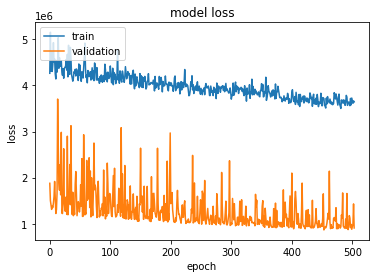

In [127]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(work_dir, 'my_model.h5'))

In [187]:
# Test Set performance
nn_scores = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(nn_scores)

[697907.9264068344, 835.4089, 578.3888]


In [128]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(os.path.join(work_dir, 'my_model.h5'))
new_model.load_weights(os.path.join(work_dir, "weights.best.hdf5"))
# Show the model architecture
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               32256     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 89,985
Trainable params: 89,985
Non-trainable params: 0
_________________________________________________________________


In [129]:
new_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

[631733.4727558653, 794.8166, 571.64795]

A Pure Polynomial Model

In [124]:
def print_cv_score(model, x, y, cv=5, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv)
    if scoring == 'neg_mean_squared_error':
        scores = np.sqrt(-scores)
    elif scoring == 'neg_mean_absolute_error':
        scores = -scores
    print("CV Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores

lr = LinearRegression()
lr_poly2_rmse_scores = print_cv_score(lr, X_train_poly, y_train_scaled)
lr_poly2_mae_scores = print_cv_score(lr, X_train_poly, y_train_scaled, scoring='neg_mean_absolute_error')
lr_poly2_r2_scores = print_cv_score(lr, X_train_poly, y_train_scaled, scoring='r2')

CV Score: 1137.49 (+/- 42.59)
CV Score: 843.04 (+/- 34.81)
CV Score: 0.93 (+/- 0.00)
